# K-NN(TF-IDF,AVG W2V)

In [1]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

In [2]:
con =sqlite3.connect('finaldb.sqlite')

In [3]:
final = pd.read_sql_query("""
SELECT * FROM Reviews
""",con)

def partition(x):
    if x == "negative":
        return 0
    return 1

actualScore = final['Score']

positiveNegative = actualScore.map(partition) 
final['Score'] = positiveNegative

In [4]:
print(final.shape)

(87773, 12)


In [5]:
df_100 = final.sample(n=50000)

In [6]:
df_100['Score'].value_counts()

1    41942
0     8058
Name: Score, dtype: int64

In [7]:
#orting the data according to the Time
df_100=df_100.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [8]:
#split the data set into train and test
y=df_100['Score']
X_1=df_100[0:35000]
X_test=df_100[35000:50000]
y_1=y[0:35000]
y_test=y[35000:50000]

In [9]:
tf_idf_vect= TfidfVectorizer()
X_1=tf_idf_vect.fit_transform(X_1['Text'].values)

In [10]:
# split the train data set into cross validation train and cross validation test
X_train=X_1[0:24500]
y_train=y_1[0:24500]
X_cv=X_1[24500:35000]
y_cv=y_1[24500:35000]

In [11]:
#coverting into document matrix of test data 
X_test = tf_idf_vect.transform(X_test['Text'].values)

In [12]:
import warnings
warnings.filterwarnings("ignore")

In [13]:
# ============================== loading libraries ===========================================
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
# =============================================================================================

In [ ]:
for i in range(1,20,2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_cv)
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %f%%' % (i, acc))
    


CV accuracy for k = 1 is 79.390476%

CV accuracy for k = 3 is 82.980952%

CV accuracy for k = 5 is 83.561905%

CV accuracy for k = 7 is 83.400000%

CV accuracy for k = 9 is 83.666667%

CV accuracy for k = 11 is 83.714286%

CV accuracy for k = 13 is 83.600000%

CV accuracy for k = 15 is 83.580952%

CV accuracy for k = 17 is 83.438095%

CV accuracy for k = 19 is 83.400000%


In [14]:
#checking the test accuracy with k=11
knn = KNeighborsClassifier(11)
knn.fit(X_train,y_train)
pred = knn.predict(X_test)
acc = accuracy_score(y_test, pred, normalize=True) * float(100)
print('\n****Test accuracy for k = 11 is %f%%' % (acc))


****Test accuracy for k = 11 is 84.140000%


In [15]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test, pred)
print(cm)

[[  280  2315]
 [   64 12341]]


Text(0.5,1,'Confusion Matrix\n')

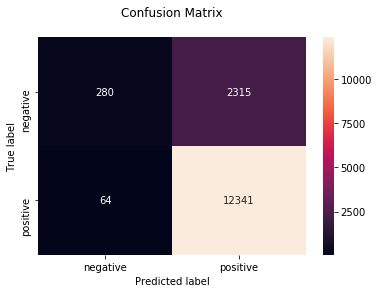

In [16]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
ax=plt.subplot()
sns.heatmap(cm,annot=True,ax=ax,fmt='d')
#labels
ax.set_xlabel('Predicted label');
ax.set_ylabel('True label')
ax.xaxis.set_ticklabels(['negative','positive']);
ax.yaxis.set_ticklabels(['negative','positive'])
plt.title("Confusion Matrix\n")

# 10-fold cross validation 


The optimal number of neighbors is 11.


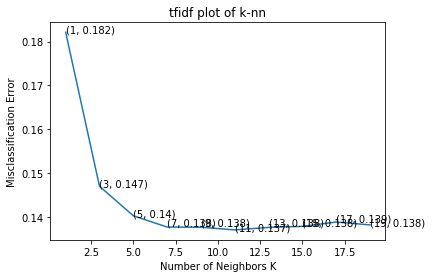

the misclassification error for each k value is :  [0.182 0.147 0.14  0.138 0.138 0.137 0.138 0.138 0.139 0.138]


In [17]:
# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.title('tfidf plot of k-nn')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [18]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)

# fitting the model
knn_optimal.fit(X_train, y_train)

# predict the response
pred = knn_optimal.predict(X_test)

# evaluate accuracy
acc = accuracy_score(y_test, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 11 is 84.140000%


# word2vec

In [19]:
#sorting the data according to the Time
w2v=df_100.sort_values('Time',axis=0,ascending=True,inplace=False,kind='quicksort',na_position='last')

In [20]:
import re
import nltk
#nltk.download('stopwords')
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'down', 'on', 'off', 'those', 'couldn', 'it', 'and', 'very', 'was', 'the', 'herself', 'having', "hasn't", 'aren', 'yourselves', 'why', 'shouldn', 'd', 'its', 'wasn', 'too', "don't", 'a', 'so', "isn't", 'this', 'nor', 'mightn', 'yours', 'll', 'when', 'that', 'needn', 'hers', 'itself', 'being', 'i', 'now', "couldn't", 'which', 'who', 'is', 'by', 'with', 't', 've', 'again', 'am', "hadn't", "that'll", 'these', 'out', 'only', "mightn't", 'can', 'your', 'if', 'any', 'hadn', 'other', 'themselves', 'o', "shan't", 'ours', "needn't", "shouldn't", 'they', 're', 'm', 'below', 'further', 'then', 'haven', 'at', "you're", 'both', "should've", "haven't", 'had', 'what', 'over', 'whom', "aren't", 'my', 'own', 'him', 'ain', 'ourselves', 'are', 'have', 'most', 'ma', 'before', 'how', 'there', 'himself', 'me', 'were', 'theirs', 'such', 'her', 'won', 'in', 'didn', 'will', 'their', 'she', 'during', 'more', 'as', 'our', 's', 'after', 'while', 'all', 'through', 'under', "wouldn't", 'isn', 'just', 'weren', 'tha

In [21]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
i=0
list_of_sent=[]
for sent in w2v['Text'].values:
    filtered_sentence=[]
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [22]:
import gensim
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    

In [23]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

50000
50


In [24]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation


In [31]:
#split the data set into train and test
y=df_100['Score']
X_1=sent_vectors[0:35000]
X_test=sent_vectors[35000:50000]
y_1=y[0:35000]
y_test=y[35000:50000]
# split the train data set into cross validation train and cross validation test
X_train=X_1[0:24500]
y_train=y_1[0:24500]
X_cv=X_1[24500:35000]
y_cv=y_1[24500:35000]

In [27]:
#K-NN
for i in range(1,20,2):
    knn = KNeighborsClassifier(n_neighbors=i)

    # fitting the model on crossvalidation train
    knn.fit(X_train, y_train)

    # predict the response on the crossvalidation train
    pred = knn.predict(X_cv)

    # evaluate CV accuracy
    acc = accuracy_score(y_cv, pred, normalize=True) * float(100)
    print('\nCV accuracy for k = %d is %f%%' % (i, acc))   


CV accuracy for k = 1 is 73.342857%

CV accuracy for k = 3 is 78.666667%

CV accuracy for k = 5 is 80.838095%

CV accuracy for k = 7 is 81.476190%

CV accuracy for k = 9 is 81.895238%

CV accuracy for k = 11 is 81.904762%

CV accuracy for k = 13 is 82.028571%

CV accuracy for k = 15 is 82.038095%

CV accuracy for k = 17 is 82.047619%

CV accuracy for k = 19 is 82.057143%



The optimal number of neighbors is 19.


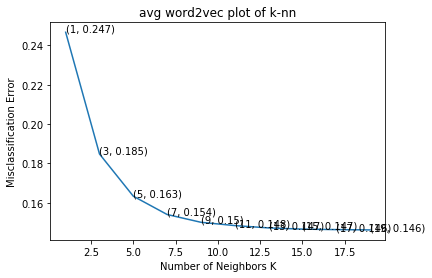

the misclassification error for each k value is :  [0.247 0.185 0.163 0.154 0.15  0.148 0.147 0.147 0.146 0.146]


In [29]:


# creating odd list of K for KNN
myList = list(range(0,20))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.title('avg word2vec plot of k-nn')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [35]:
# instantiate learning model k = optimal_k
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
# fitting the model
knn_optimal.fit(X_train, y_train)
# predict the response

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='uniform')

In [37]:
pred = knn_optimal.predict(X_cv)
# evaluate accuracy
acc = accuracy_score(y_cv, pred) * 100
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 19 is 82.057143%


# Summary

| Model|Hyperparameter|Test Accuracy|
|------|------|------|
|K-NN on TF-IDF  |K=11|84.14% |
|K-fold on TF-IDF  |K=11 |84.14%  |
|K-NN on word2vec|K=19|82.05%|
|K-fold on word2vec|K=19|82.05% |